# Non linear heat equqation with PINN

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
import numpy as np

In [3]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

%matplotlib inline

In [4]:
import warnings
warnings.filterwarnings('ignore')

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print('Utilizando el dispositivo ',device)

Utilizando el dispositivo  cuda


In [6]:
# Definir la arquitectura de la red neuronal
class PINN(nn.Module):
    def __init__(self, input_size, output_size, hidden_layers, hidden_neurons):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_neurons))
        for _ in range(hidden_layers):
            self.layers.append(nn.Linear(hidden_neurons, hidden_neurons))
        self.layers.append(nn.Linear(hidden_neurons, output_size))

    def forward(self, x):
        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))
        x = self.layers[-1](x)
        return x

In [7]:
# Función para calcular la conductividad térmica no lineal k(u)
def k(u):
    return 1 + u**2

In [8]:
# Función de la fuente de calor f(x, y, u, t)
def f(x, y, u, t):
    return x*y*u + t

In [9]:
def loss_function(u, u_t, k_u, u_x, u_y, u_xx, u_yy, x, y, t):
    heat_equation_residual = u_t - (k_u * (u_xx + u_yy))
    f_val = f(x, y, t, u)  # Evaluar la función f en los puntos de entrenamiento
    return torch.mean((heat_equation_residual - f_val)**2)

In [10]:
# Crear y entrenar el modelo
input_size = 3
output_size = 1
hidden_layers = 4
hidden_neurons = 50
learning_rate = 0.001
epochs = 5000

model = PINN(input_size, output_size, hidden_layers, hidden_neurons).to(device)
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [11]:
from torchsummary import summary

# Asumiendo que el modelo ya está definido y creado como la variable 'model'
# y el tamaño de entrada es (3,) para (x, y, t)
input_size = (3,)

# Usa la función summary para mostrar un resumen del modelo
summary(model, input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                   [-1, 50]             200
            Linear-2                   [-1, 50]           2,550
            Linear-3                   [-1, 50]           2,550
            Linear-4                   [-1, 50]           2,550
            Linear-5                   [-1, 50]           2,550
            Linear-6                    [-1, 1]              51
Total params: 10,451
Trainable params: 10,451
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.04
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


In [12]:
def predict_temperature(x, y, t):
    input_data = torch.tensor([[x, y, t]], dtype=torch.float32).to(device)
    temperature = model(input_data).detach().cpu().numpy()[0, 0]
    return temperature

In [13]:
# Crear una lista vacía para almacenar la pérdida en cada época
loss_history = []

# Generar puntos de entrenamiento
x_train = torch.tensor(np.random.rand(1000, 1), dtype=torch.float32, requires_grad=True).to(device)
y_train = torch.tensor(np.random.rand(1000, 1), dtype=torch.float32, requires_grad=True).to(device)
t_train = torch.tensor(np.random.rand(1000, 1), dtype=torch.float32, requires_grad=True).to(device)
train_data = torch.cat((x_train, y_train, t_train), dim=1)

for epoch in range(epochs):
    optimizer.zero_grad()
    u = model(train_data)

    u_t = torch.autograd.grad(u.sum(), t_train, create_graph=True)[0]
    k_u = k(u)
    u_x = torch.autograd.grad(u.sum(), x_train, create_graph=True)[0]
    u_y = torch.autograd.grad(u.sum(), y_train, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x.sum(), x_train, create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y.sum(), y_train, create_graph=True)[0]

    loss = loss_function(u, u_t, k_u, u_x, u_y, u_xx, u_yy, x_train, y_train, t_train)
    loss.backward()
    optimizer.step()
    
    # Convertir la pérdida a un escalar y agregarla a la lista de pérdidas
    loss_history.append(loss.item())

    if epoch % 500 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

Epoch: 0, Loss: 0.02156446874141693
Epoch: 500, Loss: 0.000604662811383605
Epoch: 1000, Loss: 0.0006104466156102717
Epoch: 1500, Loss: 0.0007119111251085997
Epoch: 2000, Loss: 0.0009020804427564144
Epoch: 2500, Loss: 0.0010275553213432431
Epoch: 3000, Loss: 0.0011361336801201105
Epoch: 3500, Loss: 0.0012768593151122332
Epoch: 4000, Loss: 0.001144000911153853
Epoch: 4500, Loss: 0.0012653181329369545


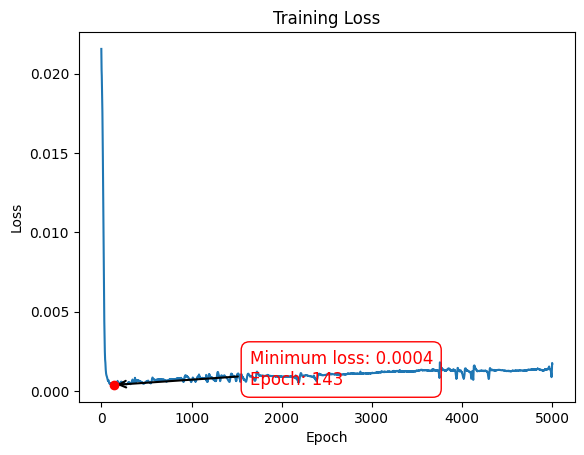

In [ ]:
# Encontrar el mínimo y su índice (número de época)
min_loss = np.min(loss_history)
min_loss_epoch = np.argmin(loss_history)

# Graficar la pérdida en función del número de épocas
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

# Resaltar el mínimo con un punto
plt.scatter(min_loss_epoch, min_loss, color='red', marker='o', zorder=5)

# Anotar el número de época y el valor mínimo en el gráfico
annotation = f'Minimum loss: {min_loss:.4f}\nEpoch: {min_loss_epoch}'
plt.annotate(annotation, xy=(min_loss_epoch, min_loss), xytext=(min_loss_epoch + 0.3 * epochs, min_loss * 5),
             arrowprops=dict(arrowstyle='->', lw=1.5),
             fontsize=12, color='red', bbox=dict(facecolor='none', edgecolor='red', boxstyle='round,pad=0.5'))

plt.show()

In [15]:
# Función para predecir la temperatura usando el modelo entrenado
def predict_temperature(x, y, t):
    input_data = torch.tensor([[x, y, t]], dtype=torch.float32).to(device)
    temperature = model(input_data).detach().cpu().numpy()[0, 0]|
    return temperature

In [16]:
# Animación de la simulación
x_values = np.linspace(0, 1, 50)
y_values = np.linspace(0, 1, 50)
t_values = np.linspace(0, 1, 20)

X, Y = np.meshgrid(x_values, y_values)
temperatures = np.zeros((len(y_values), len(x_values), len(t_values)))

In [17]:
for t_idx, t in enumerate(t_values):
    for i, x in enumerate(x_values):
        for j, y in enumerate(y_values):
            temperatures[j, i, t_idx] = predict_temperature(x, y, t)

In [18]:
def update_temperature_image(t_idx):
    im.set_array(temperatures[:, :, t_idx])
    return [im]

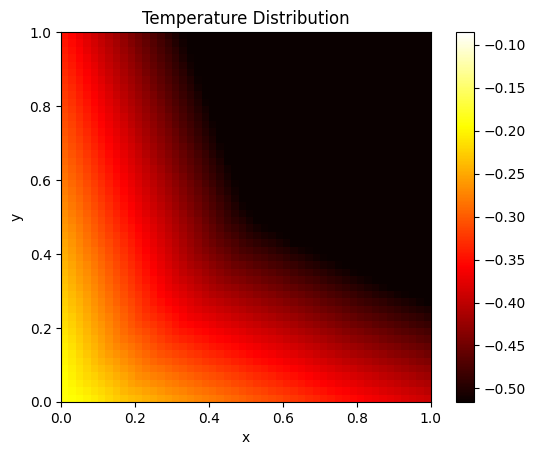

In [19]:
fig, ax = plt.subplots()
im = ax.imshow(temperatures[:, :, 0], cmap='hot', animated=True, extent=[0, 1, 0, 1], origin='lower')

ani = animation.FuncAnimation(fig, update_temperature_image, frames=len(t_values), blit=True, interval=100)
plt.colorbar(im, ax=ax)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Temperature Distribution')

# Utiliza HTML para mostrar la animación en un cuaderno Jupyter
HTML(ani.to_jshtml())

## Circle domain

In [20]:
import numpy as np

In [21]:
import torch
import torch.nn as nn

In [22]:
# Dispositivo
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [23]:
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

In [24]:
# Funciones f y k
def f(x, y, t, u):
    return -u * (x**2 + y**2) * torch.sin(np.pi * t)

In [25]:
def k(u):
    return 1 + u**2

In [26]:
# Modelo PINN
class PINN(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_hidden):
        super(PINN, self).__init__()
        self.layers = nn.ModuleList()
        self.layers.append(nn.Linear(input_size, hidden_size))
        for _ in range(num_hidden):
            self.layers.append(nn.Linear(hidden_size, hidden_size))
        self.layers.append(nn.Linear(hidden_size, output_size))
    
    def forward(self, x):
        for layer in self.layers[:-1]:
            x = torch.relu(layer(x))
        x = self.layers[-1](x)
        return x

In [27]:
# Función de pérdida
def loss_function(u, u_t, k_u, u_x, u_y, u_xx, u_yy, x, y, t):
    heat_equation_residual = u_t - (k_u * (u_xx + u_yy))
    f_val = f(x, y, t, u)
    return torch.mean((heat_equation_residual - f_val)**2)

In [28]:
# Función de predicción de temperatura
def predict_temperature(x, y, t):
    input_data = torch.tensor([[x, y, t]], dtype=torch.float32).to(device)
    temperature = model(input_data).detach().cpu().numpy()[0, 0]
    return temperature

In [29]:
# Función de actualización de imagen de temperatura
def update_temperature_image(t_idx):
    im.set_array(temperatures[:, :, t_idx])
    return [im]

In [30]:
# Parámetros
input_size = 3
output_size = 1
hidden_size = 100
num_hidden = 5
learning_rate = 0.001
epochs = 5000

In [31]:
# Crear el modelo y enviarlo al dispositivo
model = PINN(input_size, output_size, hidden_size, num_hidden).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [32]:
from torchsummary import summary

# Asumiendo que el modelo ya está definido y creado como la variable 'model'
# y el tamaño de entrada es (3,) para (x, y, t)
input_size = (3,)

# Usa la función summary para mostrar un resumen del modelo
summary(model, input_size)

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 100]             400
            Linear-2                  [-1, 100]          10,100
            Linear-3                  [-1, 100]          10,100
            Linear-4                  [-1, 100]          10,100
            Linear-5                  [-1, 100]          10,100
            Linear-6                  [-1, 100]          10,100
            Linear-7                    [-1, 1]             101
Total params: 51,001
Trainable params: 51,001
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.19
Estimated Total Size (MB): 0.20
----------------------------------------------------------------


In [33]:
# Generar puntos de entrenamiento en un dominio circular
num_points = 1000
radius = 0.5
theta = 2 * np.pi * np.random.rand(num_points, 1)
r = radius * np.sqrt(np.random.rand(num_points, 1))
x_train = 0.5 + r * np.cos(theta)
y_train = 0.5 + r * np.sin(theta)
t_train = np.random.rand(num_points, 1)

In [34]:
x_train = torch.tensor(x_train, dtype=torch.float32, requires_grad=True).to(device)
y_train = torch.tensor(y_train, dtype=torch.float32, requires_grad=True).to(device)
t_train = torch.tensor(t_train, dtype=torch.float32, requires_grad=True).to(device)
train_data = torch.cat((x_train, y_train, t_train), dim=1)

In [35]:
# Crear una lista vacía para almacenar la pérdida en cada época
loss_history = []

# Entrenamiento del modelo
for epoch in range(epochs):
    optimizer.zero_grad()
    u = model(train_data)
    u_t = torch.autograd.grad(u.sum(), t_train, create_graph=True)[0]
    k_u = k(u)
    u_x = torch.autograd.grad(u.sum(), x_train, create_graph=True)[0]
    u_y = torch.autograd.grad(u.sum(), y_train, create_graph=True)[0]
    u_xx = torch.autograd.grad(u_x.sum(), x_train, create_graph=True)[0]
    u_yy = torch.autograd.grad(u_y.sum(), y_train, create_graph=True)[0]
    
    loss = loss_function(u, u_t, k_u, u_x, u_y, u_xx, u_yy, x_train, y_train, t_train)
    loss.backward()
    optimizer.step()
    
    # Convertir la pérdida a un escalar y agregarla a la lista de pérdidas
    loss_history.append(loss.item())
    
    if epoch % 500 == 0:
        print(f'Epoch: {epoch}, Loss: {loss.item()}')

Epoch: 0, Loss: 0.0014580143615603447
Epoch: 500, Loss: 7.112241906526151e-09


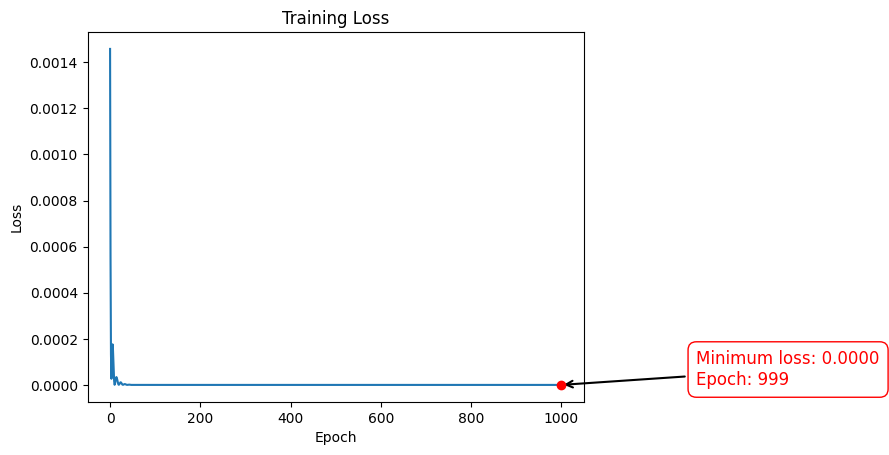

In [36]:
# Encontrar el mínimo y su índice (número de época)
min_loss = np.min(loss_history)
min_loss_epoch = np.argmin(loss_history)

# Graficar la pérdida en función del número de épocas
plt.plot(loss_history)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')

# Resaltar el mínimo con un punto
plt.scatter(min_loss_epoch, min_loss, color='red', marker='o', zorder=5)

# Anotar el número de época y el valor mínimo en el gráfico
annotation = f'Minimum loss: {min_loss:.4f}\nEpoch: {min_loss_epoch}'
plt.annotate(annotation, xy=(min_loss_epoch, min_loss), xytext=(min_loss_epoch + 0.3 * epochs, min_loss),
             arrowprops=dict(arrowstyle='->', lw=1.5),
             fontsize=12, color='red', bbox=dict(facecolor='none', edgecolor='red', boxstyle='round,pad=0.5'))

plt.show()

In [37]:
# Crear una malla de puntos para evaluar la solución en el dominio circular
resolution = 100
theta_values = np.linspace(0, 2 * np.pi, resolution)
r_values = np.linspace(0, radius, resolution)

x_values = 0.5 + r_values * np.cos(theta_values)[:, None]
y_values = 0.5 + r_values * np.sin(theta_values)[:, None]

In [39]:
# Evaluar la solución en la malla circular
t_values = np.linspace(0, 1, 50)
temperatures = np.zeros((resolution, resolution, len(t_values)))

x_values_tensor = torch.tensor(x_values, device=device, dtype=torch.float32)
y_values_tensor = torch.tensor(y_values, device=device, dtype=torch.float32)

for t_idx, t in enumerate(t_values):
    t_tensor = torch.full_like(x_values_tensor, t, device=device, dtype=torch.float32)

    input_data = torch.stack((x_values_tensor, y_values_tensor, t_tensor), dim=-1)
    temperature = model(input_data).detach().cpu().numpy()

    temperatures[:, :, t_idx] = temperature.squeeze()

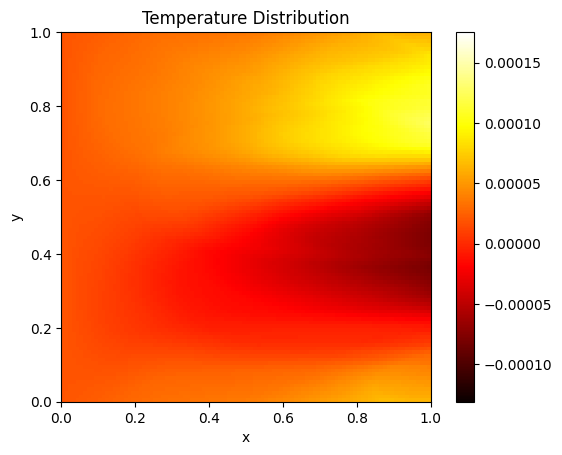

In [40]:
# Visualizar la animación
fig, ax = plt.subplots()
im = ax.imshow(temperatures[:, :, 0], cmap='hot', animated=True, extent=[0, 1, 0, 1], origin='lower')

ani = animation.FuncAnimation(fig, update_temperature_image, frames=len(t_values), blit=True, interval=100)
plt.colorbar(im, ax=ax)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Temperature Distribution')
# plt.show()


# Utiliza HTML para mostrar la animación en un cuaderno Jupyter
HTML(ani.to_jshtml())

## Dominio circular

In [45]:
from matplotlib.patches import Circle

In [41]:
# Crear una malla circular
theta = np.linspace(0, 2 * np.pi, resolution)
radius = np.linspace(0, 1, resolution)
t_values = np.linspace(0, 1, 50)
theta_mesh, radius_mesh = np.meshgrid(theta, radius)

x_values = radius_mesh * np.cos(theta_mesh)
y_values = radius_mesh * np.sin(theta_mesh)

temperatures = np.zeros((resolution, resolution, len(t_values)))

x_values_tensor = torch.tensor(x_values, device=device, dtype=torch.float32)
y_values_tensor = torch.tensor(y_values, device=device, dtype=torch.float32)

In [42]:
for t_idx, t in enumerate(t_values):
    t_tensor = torch.full_like(x_values_tensor, t, device=device, dtype=torch.float32)

    input_data = torch.stack((x_values_tensor, y_values_tensor, t_tensor), dim=-1)
    temperature = model(input_data).detach().cpu().numpy().squeeze()

    temperatures[:, :, t_idx] = temperature


In [48]:
# Función para actualizar la imagen de la animación
def update_temperature_image(i):
    z = temperatures[:, :, i]
    z_masked = np.ma.masked_where(circle_mask == 0, z)
    pc.set_array(z_masked.ravel())
    return [pc]

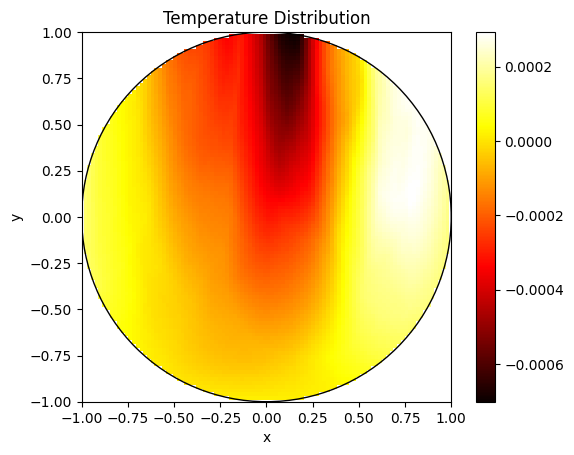

In [49]:
# Crear el gráfico y configurar la animación
fig, ax = plt.subplots()
x_plot, y_plot = np.meshgrid(np.linspace(-1, 1, resolution), np.linspace(-1, 1, resolution))
circle_mask = x_plot ** 2 + y_plot ** 2 <= 1

z = temperatures[:, :, 0]
z_masked = np.ma.masked_where(circle_mask == 0, z)
pc = ax.pcolormesh(x_plot, y_plot, z_masked, cmap='hot', shading='auto')
circle = Circle((0, 0), 1, fill=False, edgecolor='black')
ax.add_patch(circle)

ax.set_xlim(-1, 1)
ax.set_ylim(-1, 1)
ax.set_aspect('equal')

ani = animation.FuncAnimation(fig, update_temperature_image, frames=len(t_values), blit=True, interval=100)
plt.colorbar(pc, ax=ax)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Temperature Distribution')
plt.show()
# Utiliza HTML para mostrar la animación en un cuaderno Jupyter
HTML(ani.to_jshtml())